# Analysis of brainstorming transcript : divergent processes
The following is an ongoing analysis of transcripts from 18 teams; 9 of the teams performed what is called "free" brainstorming
The remaining 9 performed an alternating divergent-convergent process. The transcript for each team is split into its divergent and convergent components. 
This analysis concerns only the divergent components.

## Code credits
A lot of this code is inspired from, and in several cases reused directly from the code written by Moses Boudourides, Sergios Lenis & Pantelis Vikatos. Their version can be seen at:
http://mboudour.github.io/2016/03/22/Clinton-Sanders-Word-Nets.html

We change some aspects of the commonality functions and co-occurrence functions to suit our requirements, see code comments that accompany these functions below for details.

In [58]:
# Get all imports out of the way
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
from nltk.corpus import stopwords
from nltk.corpus.reader.wordnet import information_content
from nltk.tokenize import sent_tokenize
import itertools
import codecs
import re
import pprint as pp
import operator
from collections import OrderedDict
from collections import Counter
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

## Step 1: Read Files
We first read the transcript text files. Each team's transcript is split into sections of
"divergent" processes (idea generation) and of "convergent" processes (idea evaluation/selection).
For this analysis, we will only look at the divergent processes. The goal is to understand what 
concepts are common between the two groups (Free and D-C), and what concepts are unique to each group.

In [59]:
# Locations of input files. These files have been anonymized, and the files themselves will not be available
# in this folder, to preserve the privacy of the teams.
textPathFree = "../../../private/brainstorming_viz_data/free_group/"
textPathDC = "../../../private/brainstorming_viz_data/d-c_group/"

# Teamwise transcript (of divergent processes) of the "Free Brainstorming" group
fileNamesFree = ['teamA_part1_divergent.txt',
                 'teamB_part1_divergent.txt',
                 'teamC_part1_divergent.txt',
                 'teamD_part1_divergent.txt',
                 'teamE_part1_divergent.txt',
                 'teamF_part1_divergent.txt',
                 'teamG_part1_divergent.txt',
                 'teamH_part1_divergent.txt',
                 'teamI_part1_divergent.txt']

# Teamwise transcript (of divergent processes) of the "Divergent-Convergent (D-C) Brainstorming" group
fileNamesDC = ['teamJ_part1_divergent.txt',
               'teamJ_part3_divergent.txt',
               'teamK_part1_divergent.txt',
               'teamK_part3_divergent.txt',
               'teamL_part1_divergent.txt',
               'teamL_part3_divergent.txt',
               'teamM_part1_divergent.txt',
               'teamM_part2_3_convergent_divergent.txt',
               'teamN_part1_divergent.txt',
               'teamN_part3_divergent.txt',
               'teamO_part1_divergent.txt',
               'teamO_part2_3_conv_div.txt',
               'teamP_part1_divergent.txt',
               'teamP_part3_divergent.txt',
               'teamQ_part1_divergent.txt',
               'teamQ_part3_4_div_conv.txt',
               'teamR_part1_divergent.txt',
               'teamR_part3_divergent.txt'] 

def openFiles(fileNamesList, filePath):
    # Given a list of file names and a path for the files, returns a
    # list of file objects
    fObjList = []
    for fileName in fileNamesList:
        fObj = open(filePath + fileName, 'r', encoding='utf8')
        fObjList.append(fObj)
    return fObjList

filesListFree = openFiles(fileNamesFree, textPathFree)
filesListDC = openFiles(fileNamesDC, textPathDC)

## Step 2: File processing
To avoid processing errors, we first remove all non-UTF characters in the text (such as distinct opening and closing quotes)
and replace them with corresponding UTF characters.
These transcripts also come with the transcriber's observations, such as [laughter], or [silent]. We remove all such observations so that we are only looking at team members' speech.

In [60]:
# Some of these files have non-UTF characters that may need to be removed.
def removeSpecials(filesList):
    # Remove some incompatible unicode characters such as distinct
    # opening and closing quotes, ellipsis etc.
    # Also finally converts all text to lowercase
    outString = ''
    for inFile in filesList:
        # print("reading file",inFile.name.split("/")[-1], "...", end="")
        temp = inFile.read()
        subsFileQuotes = re.sub(u"(\u2018|\u2019)", "'", temp)
        subsFileDQuotes = re.sub(u'(\u201c|\u201d)', '"', subsFileQuotes)
        subsFileEllipsis = re.sub(u"\u2026", "...", subsFileDQuotes)
        outString += subsFileEllipsis
        # print("done.")
    return outString.lower()

group1_divergent_raw = removeSpecials(filesListFree)
group2_divergent_raw = removeSpecials(filesListDC)

In [61]:
# These files have the transcriber's observations like [laughter], [silent], [cross-talk] etc.
# These may throw off the text analysis, so we remove them. These are typically within parantheses,
# so we can remove everything between these parantheses.

def removeObservations(test_str) :
    # removes all text within parantheses
    # these are usually observations by the transcriber
    # and thus should not be considered in content analysis
    # code from http://stackoverflow.com/questions/14596884/remove-text-between-and-in-python
    ret = ''
    skip1c = 0
    skip2c = 0
    squareparen = 0
    for i in test_str:
        if i == '[':
            skip1c += 1
            squareparen += 1
        elif i == '(':
            skip2c += 1
        elif i == ']' and skip1c > 0:
            skip1c -= 1
        elif i == ')'and skip2c > 0:
            skip2c -= 1
        elif skip1c == 0 and skip2c == 0:
            ret += i
    print("Number of observations removed", str(squareparen))
    return ret

group1_divergent = removeObservations(group1_divergent_raw)
group2_divergent = removeObservations(group2_divergent_raw)

Number of observations removed 1128
Number of observations removed 657


## Step 3: Tokenizing and stop word removal
We split the text from the transcripts into individual words. Of these, we remove "stop words" -- common words that add little meaning, such as articles, pronouns, prepositions etc. 
An added step would be to then "lemmatize" the resulting words so that words such as "short", "shorter", and "shortest" are treated the same (short), and words with different tenses, singular/plural forms etc. are also treated the same. However, we will do this at a later stage so that we can first identify all occurrences of the filtered words in the original text. To do this, we will need to implement whole-word matches, which will not be accurate if we were to lemmatize first.

In [62]:
# Split the file into words using a tokenizer
# Also name the variables a little more meaningfully
freeWords = nltk.word_tokenize(group1_divergent) 
DCWords = nltk.word_tokenize(group2_divergent)

# Remove stop words
freeWordsFiltered = [w for w in freeWords if not w in stopwords.words('english')]
DCWordsFiltered = [w for w in DCWords if not w in stopwords.words('english')]
freeDiff = len(freeWords) - len(freeWordsFiltered)
DCDiff = len(DCWords) - len(DCWordsFiltered)
print(freeDiff, "stop words removed from a total of", len(freeWords),"in the Free group")
print(DCDiff, "stop words removed from a total of", len(DCWords), "in the Divergent-Convergent group")

26911 stop words removed from a total of 64501 in the Free group
21564 stop words removed from a total of 52138 in the Divergent-Convergent group


In [63]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
wnL = WordNetLemmatizer()
ps = PorterStemmer()

# Lemmatize the tokenized words. This reduces singular, plural forms to the same form 
# to merge different forms of the same word together.
# to speed things up, remove non-unique words
# freeWordsUnique = list(set(freeWordsFiltered))
# print(len(freeWordsFiltered), "reduced to", len(freeWordsUnique), "unique words in free brainstorming transcript.")
# lemmatize the words
def genLemma(wordList):
    lemmaList = []
    for word in wordList:
        synsets = wn.synsets(word)
        if len(synsets) > 0 :
            synset = synsets[0] # assume most common use of the word
            sName = synset.name().split('.')[0]
            sPos = synset.pos()
            wordLemma = wnL.lemmatize(sName, pos=sPos)
            lemmaList.append(wordLemma)
    return lemmaList
        
            
# freeWordsLemmatized = [wnL.lemmatize(w) for w in freeWordsFiltered]
# freeWordsLemmatized = genLemma(freeWordsFiltered)
# NOTE: trying out a version without lemmatization to see the difference
freeWordsLemmU = list(set(freeWordsFiltered))
# freeWordsLemmU = list(set(freeWordsLemmatized))
print("Words in the Free Group reduced to", len(freeWordsLemmU), "unique occurrences.")

# NOTE: We choose to not do stemming as the stems cannot be processed by the WordNet library to find infocontent.

# Do the same for the D-C group
# NOTE: For the time being, we're doing away with lemmatization.
# DCWordsLemmatized = genLemma(DCWordsFiltered)
DCWordsLemmU = list(set(DCWordsFiltered))
print("Words in the D-C Group reduced to", len(DCWordsLemmU), "unique occurrences.")

Words in the Free Group reduced to 3331 unique occurrences.
Words in the D-C Group reduced to 3188 unique occurrences.


## Step 4: Partition based on Information Content
As we can see, the resulting list of words is rather large and unmanageable. We "rank" these words based on information content.
Information content is a measure of how important a word is, and it depends on the likelihood of finding a word in a text corpus, i.e.

$$IC(w) = -log(P(w)) $$

After iterating through all the text corpora available in WordNet, we settle on the British National Corpus as most suitable for our dataset, as it has the largest overlap with our dataset.

In [64]:
def getInfoContent(wordList, corpus):
    tokens = []
    icArray = []
    nonicArray = []
    for token in wordList:
        tempNum = 0
        synsets = wn.synsets(token)
        if len(synsets) > 0:
            for synset in synsets:
                if not set([synset.pos()]).intersection(set(['a','s','r'])) :
                    synsetItem = synset
                    tempNum = 1
                    break
            if tempNum == 1:
                infoContent = information_content(synsetItem, corpus)
                icArray.append((token, infoContent))
            else :
                nonicArray.append(token)
    icDict = dict(icArray)
    icTuple = sorted(icDict.items(), key=operator.itemgetter(1),
                     reverse=True)
    return [OrderedDict(icTuple), nonicArray]

corpusName = 'ic-bnc-add1'
ic_corpus = wordnet_ic.ic(corpusName + '.dat')
print("Computing infocontent with ",corpusName," corpus...", end="")
freeGroupProcessed = getInfoContent(freeWordsLemmU, ic_corpus)
DCGroupProcessed = getInfoContent(DCWordsLemmU, ic_corpus)
print("done.")

freeGrpInfoContents = freeGroupProcessed[0]
freeGrpNonInfoContents = freeGroupProcessed[1]
DCGrpInfoContents = DCGroupProcessed[0]
DCGrpNonInfoContents = DCGroupProcessed[1]
# freeGrpFrequencies = Counter(freeWordsLemmatized)
# DCGrpFrequencies = Counter(DCWordsLemmatized)
# NOTE: recall we're not using lemmatization anymore as we will look only for "exact matches" later on.
freeGrpFrequencies = Counter(freeWordsFiltered)
DCGrpFrequencies = Counter(DCWordsFiltered)
print("Number of words in the Free Group that could have infocontent computed:", len(freeGrpInfoContents))
print("Number of words in the D-C Group that could have infocontent computed:", len(DCGrpInfoContents))

# Find words for which infocontent could not be computed


Computing infocontent with  ic-bnc-add1  corpus...done.
Number of words in the Free Group that could have infocontent computed: 2593
Number of words in the D-C Group that could have infocontent computed: 2498


In [ ]:
# Partition each group's words into 3 based on infocontent scores
print("Partitioning words based on infocontent values...\n")
freeGroup_top3rd = {}
freeGroup_mid3rd = {}
freeGroup_bottom3rd = {}

maxIC = max(freeGrpInfoContents[max(freeGrpInfoContents, key=freeGrpInfoContents.get)],
            DCGrpInfoContents[max(DCGrpInfoContents, key=DCGrpInfoContents.get)])
ic_top3rdLimit = 12
ic_mid3rdLimit = 8
for key, value in freeGrpInfoContents.items():
    if value >= ic_top3rdLimit :
        freeGroup_top3rd[key] = value
    elif value >=ic_mid3rdLimit :
        freeGroup_mid3rd[key] = value
    else :
        freeGroup_bottom3rd[key] = value
print("Partitioning by infocontent in the Free Group:")
print("Found a total of", len(freeGroup_top3rd), "words with infocontent between", ic_top3rdLimit ,"and", maxIC)
print("Found a total of", len(freeGroup_mid3rd), "words with infocontent between", ic_mid3rdLimit, "and", ic_top3rdLimit)
print("Found a total of", len(freeGroup_bottom3rd), "words with infocontent between 0 and", ic_mid3rdLimit, "\n") 

DCGroup_top3rd = {}
DCGroup_mid3rd = {}
DCGroup_bottom3rd = {}
DCGroup0_5 = {}
for key, value in DCGrpInfoContents.items():
    if value >= ic_top3rdLimit :
        DCGroup_top3rd[key] = value
    elif value >= ic_mid3rdLimit :
        DCGroup_mid3rd[key] = value
    else :
        DCGroup_bottom3rd[key] = value
print("Partitioning by infocontent in the D-C Group:")
print("Found a total of", len(DCGroup_top3rd), "words with infocontent between", ic_top3rdLimit ,"and", maxIC)
print("Found a total of", len(DCGroup_mid3rd), "words with infocontent between", ic_mid3rdLimit, "and", ic_top3rdLimit)
print("Found a total of", len(DCGroup_bottom3rd), "words with infocontent between 0 and", ic_mid3rdLimit, "\n") 


## Step 5: Identifying common & unique words
Our overarching question is to identify behavior that is common to both groups (the free brainstorming group and the divergent-convergent brainstorming group), and behavior that is unique to each group. Identifying words common to both groups and words unique to each group is how we approach this transcript analysis.

In [65]:
def commUniq(group1Dict, group2Dict, group1Freq, group2Freq):
    common = {}
    # notCommon = {}
    group1Uncommon = {}
    group2Uncommon = {}
    u=1
    for i in group1Dict:
        if i in group2Dict:
            common[i] = min(group1Freq[i], group2Freq[i])
            # notCommon[i] = (group1Freq[i], group2Freq[i])
            u+=1
        else :
            group1Uncommon[i] = group1Freq[i]
    for i in group2Dict:
        if i not in group1Dict:
            group2Uncommon[i] = group2Freq[i]
    return (common, group1Uncommon, group2Uncommon)

print("Computing words common between the two groups with infocontent between", ic_top3rdLimit ,"and", maxIC,"...", end="")
topCommon, freeGrp_top_uncommon, DCGrp_top_uncommon = commUniq(freeGroup_top3rd, DCGroup_top3rd, 
                                                               freeGrpFrequencies, DCGrpFrequencies)
print("Done.")
print("Number of common words found:", len(topCommon))
print("Number of words that unique to the free group:", len(freeGrp_top_uncommon))
print("Number of words that unique to the D-C group:", len(DCGrp_top_uncommon))

print("Computing words common between the two groups with infocontent between", ic_mid3rdLimit ,"and", ic_top3rdLimit,"...", end="")
midCommon, freeGrp_mid_uncommon, DCGrp_mid_uncommon = commUniq(freeGroup_mid3rd, DCGroup_mid3rd, 
                                                               freeGrpFrequencies, DCGrpFrequencies)
print("Done.")
print("Number of common words found:", len(midCommon))
print("Number of words that unique to the free group:", len(freeGrp_mid_uncommon))
print("Number of words that unique to the D-C group:", len(DCGrp_mid_uncommon))

print("Computing words common between the two groups with infocontent between 0 and", ic_mid3rdLimit,"...", end="")
bottomCommon, freeGrp_bottom_uncommon, DCGrp_bottom_uncommon = commUniq(freeGroup_bottom3rd, DCGroup_bottom3rd, 
                                                                        freeGrpFrequencies, DCGrpFrequencies)
print("Done.")
print("Number of common words found:", len(bottomCommon))
print("Number of words that unique to the free group:", len(freeGrp_bottom_uncommon))
print("Number of words that unique to the D-C group:", len(DCGrp_bottom_uncommon))

Computing words common between the two groups with infocontent between 12 and 1e+300 ...Done.
Number of common words found: 146
Number of words that unique to the free group: 335
Number of words that unique to the D-C group: 310
Computing words common between the two groups with infocontent between 8 and 12 ...Done.
Number of common words found: 838
Number of words that unique to the free group: 666
Number of words that unique to the D-C group: 628
Computing words common between the two groups with infocontent between 0 and 8 ...Done.
Number of common words found: 394
Number of words that unique to the free group: 214
Number of words that unique to the D-C group: 182


## Step 5.1: Remove irrelevant words##
This step is to be performed only after generating a co-occurrence network first. Exploring the interactive network shown at Step 7 below allows us to identify words that add more noise than information to the graph. This is, of course, subjectively determined. These words are removed from consideration in the procedure below.

In [66]:
# Noun phrases that can be removed:
to_be_removed = ['yea', 'up', 'down'] 

keys_to_delete = []
for key in topCommon.keys():
    if key in to_be_removed:
        keys_to_delete.append(key)
for key in keys_to_delete:
    del topCommon[key] # could not have deleted item from iterable 
                    # from within the loop
topCommonFiltered=topCommon.keys()
print("Number of common words in the top third after filtering:", len(topCommonFiltered))

Number of common words in the top third after filtering: 146


## Step 6: Identify co-occurrences
We go over each sentence in the original dataset and look for word co-occurrences; pairs of words that occur in the same sentence. This helps us draw a concept map for each group's divergent brainstorming transcript data.

### NOTE
In this part of the analysis, we only look at words that are in the top stratum of information content (see results above).

In [67]:
# Function to count co-occurrences of common noun phrases in sentences
# NOTE: We're not using the function "occurrences" as found in the reference code anymore 
# as it returns partial matches, i.e. if it has to look for the word "rig" it returns sentences
# that have the word "right" but not "rig", creating a false count.
# it also seems to consider the co-occurrences of word A and word B separately if A occurs before B
# from when B occurs before A. We rectify these issues below.

# Use the function altOccurrences below instead.
# That function will in turn call the below regexp to find whole words.
def findWholeWord(w):
    # regular expression to find whole words
    return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search

def altOccurrences(source, terms):
    # This function is meant to replace "occurrences", searching for complete words.
    ALL_sentences=sent_tokenize(source) # creates a list of sentences
    combinations_terms=list(itertools.combinations(terms,2)) # NC2 of terms
    occurdict = {}
    contextdict = {}
    for i in combinations_terms:
        for j in ALL_sentences:
            match1 = findWholeWord(i[0])(j)
            match2 = findWholeWord(i[1])(j)
            if match1 and match2:
                wordkey = i[0]+" - "+i[1]
                if wordkey in contextdict:
                    contextdict[wordkey] = contextdict[wordkey] + [j]
                else :
                    contextdict[wordkey] = [j]
                if wordkey in occurdict:
                    occurdict[wordkey] = occurdict[wordkey] + 1
                else :
                    occurdict[wordkey] = 1
    return (occurdict, contextdict)
                
# Call function to find divergent and convergent terms
freeCooccur_top, freeContext_top = altOccurrences(group1_divergent, topCommon)
print("Number of unique co-occurrences found in the Free Group:", len(freeCooccur_top))
# DCCooccur_top = occurrences(group2_divergent, topCommon)
# print("Number of co-occurrences found in the D-C Group:", len(DCCooccur_top))

Number of unique co-occurrences found in the Free Group: 45


## Step 7: Plot word co-occurrence for the Free Brainstorming group
We use the data obtained in step 6 to plot a graph of co-occurrences in the "free brainstorming" group.

In [68]:
# Function to construct a graph of common noun phrases tied by 
# their co-occurrences in sentences of a transcript
def makegraph(occurrences):
    G = nx.Graph()
    weights = []
    for edgs,wt in occurrences.items():
        edg = edgs.split(' - ')
        G.add_edge(edg[0], edg[1], weight=wt)
        G.add_node(edg[0], label=edg[0])
        G.add_node(edg[1], label=edg[1])
        weights.append(wt)
    return [G, weights]

FreeGraphData = makegraph(freeCooccur_top)
GFree = FreeGraphData[0]
FreeEdges = FreeGraphData[1]

# DCGraphData = makegraph(DCCooccur_top)
# GDC = DCGraphData[0]
# DCEdges = DCGraphData[1]

In [69]:
from networkx.drawing.nx_agraph import graphviz_layout
from bokeh import mpl
from bokeh.plotting import output_notebook, show, figure
from bokeh.models import HoverTool, ColumnDataSource
output_notebook()

# First, create a graph layout
pos = nx.spring_layout(GFree, iterations=20)

def draw_interactive_network(graphObj, positions, wordFreq, wordCooccurs, wordContext, graphTitle):
    # Redrawing the graph from scratch so that the network may be interactive
    # NOTE: The current interactions are:
    # Hover on a node to show corresponding word's occurrences in the text
    # Hover on an edge center to show:
    #    * Number of co-occurrences that the edge indicates
    #    * The context, i.e., sentences in which the words co-occur.
    
    # Then obtain locations and metadata of the nodes from this layout
    xlocs = []
    ylocs = []
    nodeLabels = []
    nodeFreq = []
    nodeSizes = []
    for i in positions:
        nodeLabels.append(i)
        nodeFreq.append(str(wordFreq[i])+" occurrence(s)")
        nodeSizes.append(wordFreq[i]+10)
        xlocs.append(positions[i][0])
        ylocs.append(positions[i][1])

    # The eventual goal ofcontextHTML is to convert contextdict values 
    # from lists to html list items.
    # However, bokeh.js currently does not handle html tags *inside* variables.
    # Curently using the slightly ugly "||||" separator below
    contextHTML = {}
    for i in wordContext:
        conList = wordContext[i]
        conHTML = ""
        for item in conList:
            conHTML = conHTML + " " + item+" ||||"
        contextHTML[i] = conHTML.rstrip("|")

    # obtain locations and metadata of the edges from the layout
    edgeXpairs = []
    edgeYpairs = []
    edgeLabels = []
    edgeMidPtX = []
    edgeMidPtY = []
    edgeFreq = []
    edgeW = []
    edgeContext = []
    edgeListNames = wordCooccurs.keys()
    for i in graphObj.edges():
        w1 = i[0]
        w2 = i[1]
        w1x, w1y = positions[w1]
        w2x, w2y = positions[w2]
        edgeXpairs.append([w1x, w2x])
        edgeYpairs.append([w1y, w2y])
        edgeLabels.append(w1+" & "+w2)
        edgeMidPtX.append((w1x + w2x)/2)
        edgeMidPtY.append((w1y + w2y)/2)
        edgeString = w1 + ' - ' + w2
        edgeStringRev = w2 + ' - '+ w1
        if (edgeString in edgeListNames):
            edgeFreq.append(str(wordCooccurs[edgeString])+" co-occurrence(s)")
            edgeW.append(wordCooccurs[edgeString])
            edgeConString = contextHTML[edgeString]
            edgeContext.append(edgeConString)
        else :
            edgeFreq.append(str(wordCooccurs[edgeStringRev])+" co-occurrence(s)")
            edgeW.append(wordCooccurs[edgeStringRev])
            edgeConString = contextHTML[edgeStringRev]
            edgeContext.append(edgeConString)


    # Create a ColumnDataSource for the hover tool to reference
    dataPoints = dict(x = (xlocs + edgeMidPtX),
                      y = (ylocs + edgeMidPtY),
                      occ = (nodeFreq + edgeFreq),
                      desc = (nodeLabels + edgeLabels),
                      vis = ([1.0 for x in nodeLabels] + [0.0 for x in edgeLabels]),
                      size = (nodeSizes + [15 for x in edgeLabels]),
                      cxt = (["" for x in nodeLabels] + edgeContext))

    interact = ColumnDataSource(data = dataPoints)

    hover_data = HoverTool(tooltips ="""
                                   <text style="font-size: 17px; font-weight: bold;">@desc</text>
                                   <br>
                                   <text style="font-size: 15px">@occ</text>
                                   <div style="width:300px;font-size: 11px; font-face='Courier'">
                                       @cxt
                                   </div>
                                   """,
                                   point_policy='snap_to_data')

    p = figure(title = graphTitle, width=900, height=900)
    p.multi_line(edgeXpairs, edgeYpairs, color='gray', alpha=0.4, line_width=edgeW)
    p.circle('x', 'y', size='size', fill_color='#fed9a6', line_color=None, alpha='vis', source=interact)
    p.text(xlocs, ylocs, nodeLabels, text_font="Roboto", text_color='#333333', text_font_size='11pt', 
           text_align='center', text_baseline='middle' )

    p.add_tools(hover_data)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.visible = None
    show(p)

draw_interactive_network(GFree, pos, freeGrpFrequencies, freeCooccur_top, freeContext_top, 
                         "Co-occurrences in the Free Brainstorming Group")

Loading BokehJS ...

#### NOTE: ####
Move your mouse pointer over the **_nodes_** in the graph above to see the number of occurrences of the corresponding word in the transcript. You can also mouseover the **_mid-point of an edge_** to see both the number of co-occurrences of the two words it joins, and the context in which they co-occur.

## Step 8: Calculate centralities ##
The centralities of common words above can be calculated. Here, we look at the following centralities: NOTE: Most definitions here are from Wikipedia, but need to refine these to the definitions presented in corresponding papers.
### Betweenness Centrality ###
Defined for a node, this is equal to the number of shortest paths from all vertices to all others that pass through that node.
### Closeness Centrality ###
This is defined as the reciprocal of the sum of its distances from all other nodes.
### Degree Centality ###
This is defined as the number of links incident upon a node.
### Katz Centrality ###
Similar to Degree centrality, the Katz centrality measures the number of all nodes that can be connected through a path, while penalizing the contributions of distant nodes.
### Eigenvector Centrality ###
This is a measure of the influence of a node in a network. It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes.
### PageRank ###
Similar to Katz centrality, the pagerank measure has an additional weighting measure that weights edges on their "influence" on the network (insert equation later).

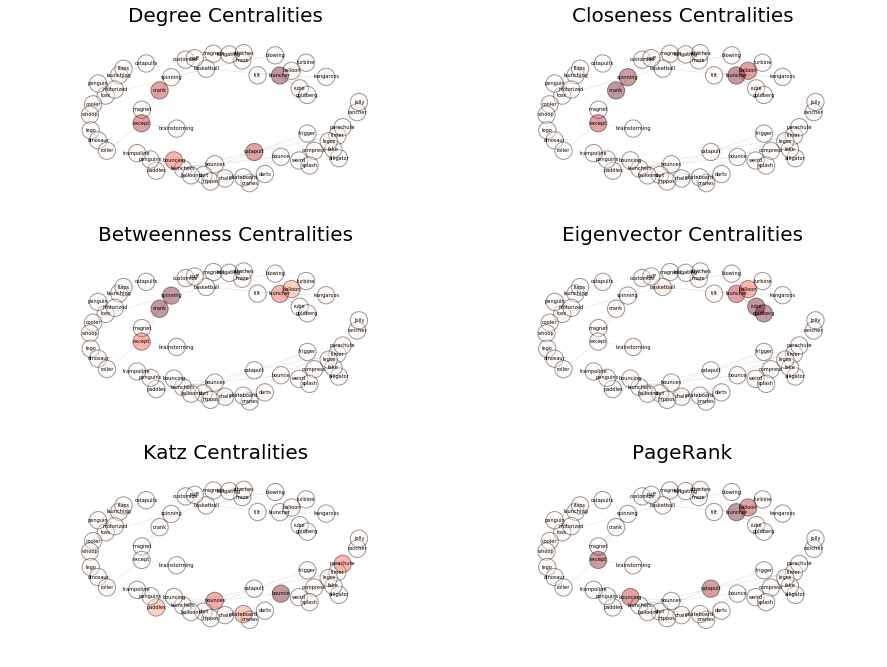

In [70]:
%matplotlib inline
from tools import draw_centralities_subplots
centrali1=draw_centralities_subplots(GFree, pos, withLabels=True,labfs=5, figsi=(15, 15), ealpha=0.15, vals=True)

## 8.1 Generate Table of Centralities of common words using occurrences in the Free Group
We list the centralities of the words common to both groups, calculated using the above metrics. Remember that this is a shortened list of words, with information content above 12.

In [71]:
# Generate Centralities Table
pd.options.display.max_rows = 999
dfchc1=pd.DataFrame()
dfchc1.insert(0,'Common Nouns', centrali1[list(centrali1.keys())[0]].keys())
u=1
for i,k in centrali1.items():
    dfchc1.insert(u,i,k.values())
dfchc1

,Common Nouns,page_rank,katz_centrality,degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality
0,customize,0.017544,-0.032049,0.017857,0.017857,0.000000,1.527251e-28
1,launchers,0.009639,0.013394,0.017857,0.044643,0.000000,3.275620e-15
2,paddles,0.008689,0.233868,0.017857,0.045918,0.000000,3.340051e-10
3,magnets,0.017544,-0.032049,0.017857,0.017857,0.000000,1.527251e-28
4,timer,0.016763,0.034171,0.035714,0.049603,0.000000,5.649125e-15
5,bouncing,0.029784,-0.159375,0.053571,0.064286,0.003896,2.844078e-09
6,catapult,0.032974,0.042688,0.071429,0.074405,0.005195,7.794196e-15
7,alligator,0.017544,-0.032049,0.017857,0.017857,0.000000,1.527251e-28
8,bounces,0.018473,0.405290,0.053571,0.071429,0.004545,1.434439e-09
9,toss,0.017544,0.080026,0.035714,0.068681,0.005844,2.434284e-11


## Step 9: Identify Communities ##
Here communities are nothing but partitions that can be made to the network. The community identification is performed using the [Louvain method](http://arxiv.org/pdf/0803.0476.pdf). Python has an [implementation of the algorithm](http://perso.crans.org/aynaud/communities/) as part of the NetworkX library.

For details refer "tools.py" in the parent directory. Identifying these partitions can help us identify "themes" to each group's transcripts, helping us understand the group's behavior better.

Number of communities of  Co-occurrences in the Free Brainstorming Group  =  17
Community partition of  Co-occurrences in the Free Brainstorming Group :
[['customize', 'attaches'],
 ['launchers', 'timer', 'catapult', 'chalk', 'trigger', 'balloons'],
 ['paddles', 'bouncing', 'bounces', 'trampoline', 'skateboard', 'bounce', 'parachute'],
 ['magnets', 'tailgating'],
 ['alligator', 'fake'],
 ['toss', 'blowing', 'spinning', 'whoop', 'maze'],
 ['crank', 'brainstorming', 'puff', 'magnet', 'roller', 'except'],
 ['penguin', 'flaps'],
 ['dart', 'penguins', 'darts'],
 ['weird', 'legos'],
 ['compress', 'splash'],
 ['launcher', 'turbine', 'basketball', 'tilt', 'balloon', 'rube', 'kangaroos', 'goldberg'],
 ['rancher', 'jolly'],
 ['launching', 'catapults'],
 ['cranes', 'hippos'],
 ['cooler', 'motorized'],
 ['lego', 'dinosaur']]
Community modularity of Co-occurrences in the Free Brainstorming Group  =  0.8429528061224489


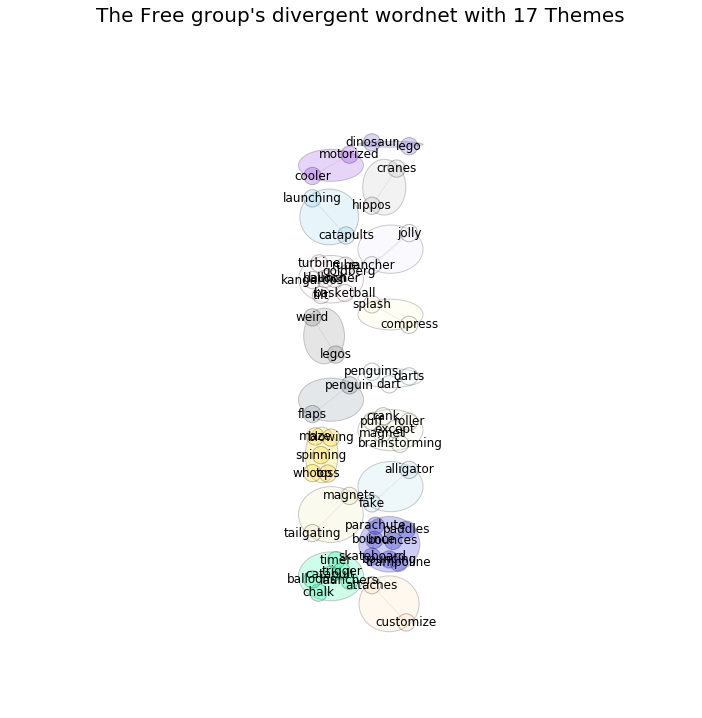

In [72]:
# detecting communities of common phrases
%reload_ext autoreload
%autoreload 2
from tools import draw_comms, modul_arity, print_communities
sstt = "Co-occurrences in the Free Brainstorming Group"
part, nodper = print_communities(GFree, sstt)

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=0.15
vcc={}

sstta="The Free group's divergent wordnet with "+ str(max(part.values())+1) + " Themes" 
draw_comms(GFree,GFree.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=12,valpha=0.25)

### Interpretation ###
An initial observation based on the communities detected and an observation of the raw data is that the communities show sets of related ideas. Based on this, we may have two possibilities:
1. **More communities with fewer words/community:** These could denote a greater "breadth" of idea genration (generating more ideas that are unrelated to each other). This should be the case for the Free brainstorming group.
2. **Fewer communities with more words/community:** These could denote a greater "depth" of ideas, i.e. a greater exploration of each idea. This should be the case for the D-C brainstorming group.

## Step 10: Perform steps 7-9 for the Divergent-Convergent Group ##

In [73]:
# Identify co-occurrences of the common words in the D-C transcript dataset
DCCooccur_top, DCContext_top = altOccurrences(group2_divergent, topCommon)
print("Number of unique co-occurrences found in the DC Group:", len(DCCooccur_top))

Number of unique co-occurrences found in the DC Group: 35


In [74]:
DCGraphData = makegraph(DCCooccur_top)
GDC = DCGraphData[0]
DCEdges = DCGraphData[1]
pos1 = nx.spring_layout(GDC, iterations=20)

In [75]:
draw_interactive_network(GDC, pos1, DCGrpFrequencies, DCCooccur_top, DCContext_top, 
                         "Co-occurrences in the D-C Brainstorming Group")

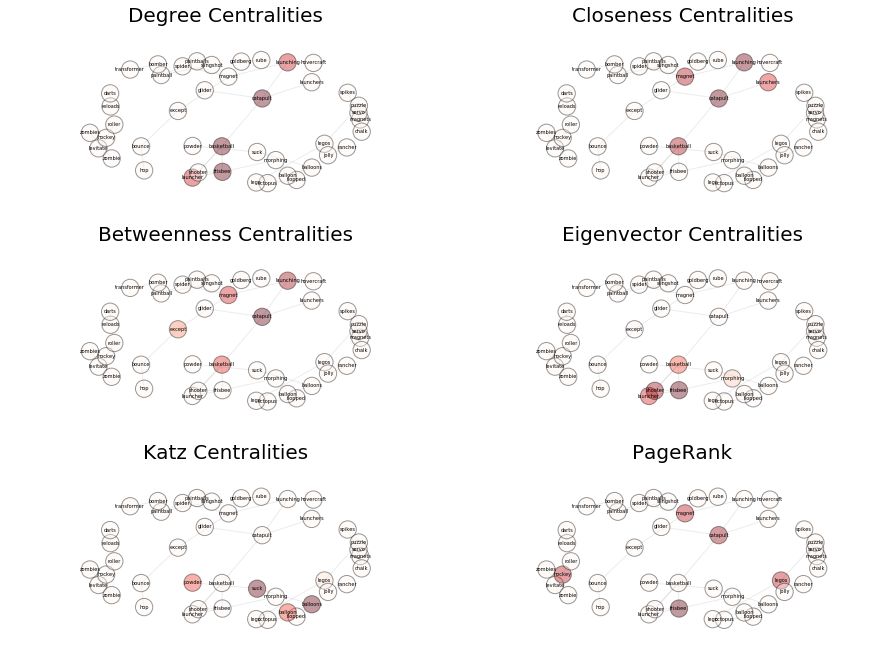

In [76]:
centrali2=draw_centralities_subplots(GDC, pos1, withLabels=True,labfs=5, figsi=(15, 15), ealpha=0.15, vals=True)

## 10.1 Generate Table of Centralities of common words using occurrences in the D-C Group
We list the centralities of the words common between the two groups, using occurrences in the D-C Group calculated using the above metrics. Remember that this is a shortened list of words, with information content above 12.

In [77]:
# Generate Centralities Table
pd.options.display.max_rows = 999
dfchc2=pd.DataFrame()
dfchc2.insert(0,'Common Nouns', centrali2[list(centrali2.keys())[0]].keys())
u=1
for i,k in centrali2.items():
    dfchc2.insert(u,i,k.values())
dfchc2

,Common Nouns,page_rank,katz_centrality,degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality
0,launchers,0.011250,0.044719,0.023256,0.101292,0.000000,1.695775e-02
1,powder,0.015949,0.360145,0.023256,0.034884,0.000000,4.596778e-14
2,levitate,0.012806,-0.008207,0.023256,0.031008,0.000000,1.765610e-10
3,magnets,0.022727,0.020453,0.023256,0.023256,0.000000,1.446387e-19
4,spider,0.012800,-0.056909,0.023256,0.089375,0.000000,8.701632e-04
5,catapult,0.036901,0.060362,0.093023,0.142442,0.066445,8.211342e-02
6,hop,0.014307,-0.042640,0.023256,0.064199,0.000000,4.057228e-05
7,reloads,0.022727,0.020453,0.023256,0.023256,0.000000,1.446387e-19
8,frisbee,0.041102,-0.016563,0.093023,0.099090,0.014396,6.123573e-01
9,hockey,0.033173,-0.026683,0.046512,0.046512,0.001107,5.296829e-10


Number of communities of  Co-occurrences in the D-C Brainstorming Group  =  15
Community partition of  Co-occurrences in the D-C Brainstorming Group :
[['launchers', 'catapult', 'launching', 'hovercraft', 'glider'],
 ['powder', 'suck', 'balloon', 'balloons'],
 ['levitate', 'hockey', 'roller'],
 ['magnets', 'spikes'],
 ['spider', 'hop', 'bounce', 'magnet', 'except'],
 ['reloads', 'darts'],
 ['frisbee', 'launcher', 'basketball', 'morphing', 'shooter'],
 ['servo', 'chalk'],
 ['rancher', 'jolly'],
 ['paintball', 'paintballs', 'slingshot'],
 ['transformer', 'bomber'],
 ['legos', 'lego', 'puzzle'],
 ['flopped', 'octopus'],
 ['zombie', 'zombies'],
 ['rube', 'goldberg']]
Community modularity of Co-occurrences in the D-C Brainstorming Group  =  0.8319452706722188


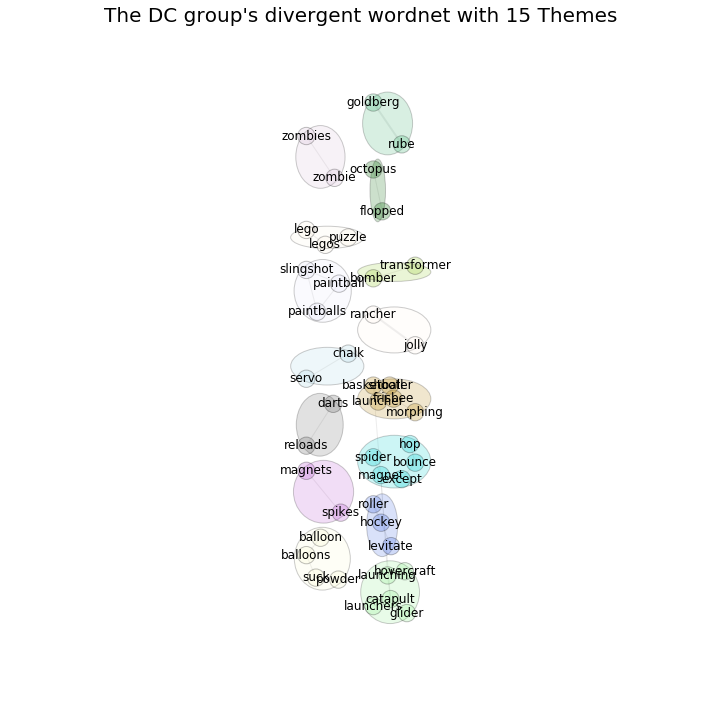

In [78]:
from tools import draw_comms, modul_arity, print_communities
sstt = "Co-occurrences in the D-C Brainstorming Group"
part, nodper = print_communities(GDC, sstt)

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=0.15
vcc={}

sstta="The DC group's divergent wordnet with "+ str(max(part.values())+1) + " Themes" 
draw_comms(GDC,GDC.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=12,valpha=0.25)

## Step 11: Perform steps 7-9 for the words unique to each group ##
Our goal is also to see what words are unique to each group, and what information they may reveal about the teams in each group. We thus perform the co-occurrence analysis and generate networks for these sets of words, too.

In [79]:
freeCooccur_top_unique, freeContext_top_unique = altOccurrences(group1_divergent, freeGrp_top_uncommon)
print("Number of unique co-occurrences found in the free Group:", len(freeCooccur_top_unique))

Number of unique co-occurrences found in the free Group: 42


In [80]:
freeGraphDataU = makegraph(freeCooccur_top_unique)
GFreeU = freeGraphDataU[0]
freeEdgesU = freeGraphDataU[1]
pos2 = nx.spring_layout(GFreeU, iterations=20)
draw_interactive_network(GFreeU, pos2, freeGrpFrequencies, freeCooccur_top_unique, freeContext_top_unique, 
                         "Co-occurrences of words unique to the Free Brainstorming Group")

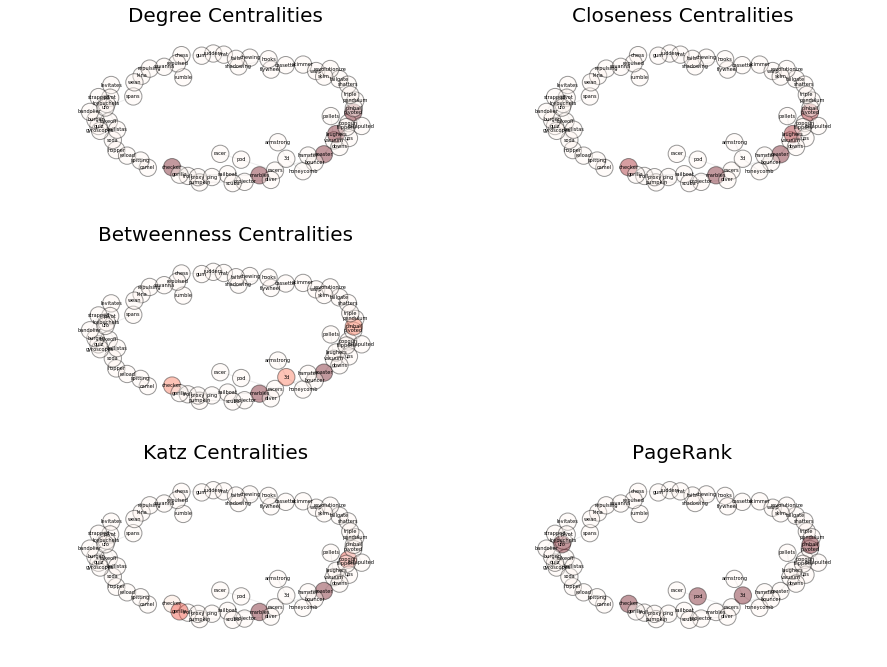

In [83]:
centrali3=draw_centralities_subplots(GFreeU, pos2, withLabels=True,labfs=5, figsi=(15, 15), ealpha=0.15, vals=True)

## 11.1 Generate Table of Centralities (Words Unique to Free Group)
We list the centralities of the words unique to the Free Group calculated using the above metrics. Remember that this is a shortened list of words, with information content above 12.

In [119]:
# Generate Centralities Table
pd.options.display.max_rows = 999
dfchc3=pd.DataFrame()
dfchc3.insert(0,'Unique Nouns', centrali3[list(centrali3.keys())[1]].keys())
u=1
for i,k in centrali3.items():
    if k != None:
        dfchc3.insert(u,i,k.values())
dfchc3

,Unique Nouns,page_rank,katz_centrality,degree_centrality,closeness_centrality,betweenness_centrality
0,spans,0.010847,0.049625,0.014286,0.019048,0.000000
1,pumpkin,0.014085,0.020517,0.014286,0.014286,0.000000
2,chewing,0.014085,0.020517,0.014286,0.014286,0.000000
3,armstrong,0.014085,0.049625,0.014286,0.019048,0.000000
4,hopper,0.010847,0.020517,0.014286,0.014286,0.000000
5,coaster,0.014085,0.580918,0.028571,0.032143,0.000828
6,vacuum,0.018285,0.020517,0.014286,0.014286,0.000000
7,troll,0.014085,0.020517,0.014286,0.014286,0.000000
8,sailboat,0.014085,0.020517,0.014286,0.014286,0.000000
9,laughers,0.014085,-0.037219,0.028571,0.028571,0.000000


In [120]:
sstt = "Co-occurrences in the Free Brainstorming Group"
part, nodper = print_communities(GFreeU, sstt)

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=0.15
vcc={}

# sstta="The Free group's divergent wordnet with "+ str(max(part.values())+1) + " Themes" 
# draw_comms(GFree,GFree.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=12,valpha=0.25)

Number of communities of  Co-occurrences in the Free Brainstorming Group  =  31
Community partition of  Co-occurrences in the Free Brainstorming Group :
[['spans', 'levitates', 'ufo'],
 ['pumpkin', 'projector'],
 ['chewing', 'gum'],
 ['hamster', 'bouncer'],
 ['3d', 'armstrong', 'honeycomb'],
 ['hopper', 'reload'],
 ['popgun', 'marbles', 'coaster', 'gorilla'],
 ['pellets', 'vacuum'],
 ['troll', 'sailboat'],
 ['pivot', 'gyroscopes'],
 ['takeoff', 'quiz'],
 ['kina', 'wean'],
 ['rudders', 'tails'],
 ['pod', 'racers', 'racer'],
 ['skimmer', 'skim'],
 ['checker', 'proxy', 'ping'],
 ['tailgate', 'revolutionize'],
 ['soda', 'burger'],
 ['pivoted', 'pendulum', 'triple'],
 ['hooks', 'shadowing'],
 ['shatters', 'warp'],
 ['cassette', 'flywheel'],
 ['ups', 'downs', 'laughers'],
 ['scuba', 'diver'],
 ['ballistas', 'trebuchets'],
 ['savanna', 'rumble'],
 ['bandolier', 'strapped'],
 ['repulsing', 'repulsed'],
 ['pinball', 'flippers', 'catapulted'],
 ['camel', 'spitting'],
 ['chess', 'mat']]
Community

In [121]:
DCCooccur_top_unique, DCContext_top_unique = altOccurrences(group2_divergent, DCGrp_top_uncommon)
print("Number of unique co-occurrences found in the DC Group:", len(DCCooccur_top_unique))

Number of unique co-occurrences found in the DC Group: 52


In [122]:
DCGraphDataU = makegraph(DCCooccur_top_unique)
GDCU = DCGraphDataU[0]
DCEdgesU = DCGraphDataU[1]
pos3 = nx.spring_layout(GDCU, iterations=20)
draw_interactive_network(GDCU, pos3, DCGrpFrequencies, DCCooccur_top_unique, DCContext_top_unique, 
                         "Co-occurrences of words unique to the DC Brainstorming Group")

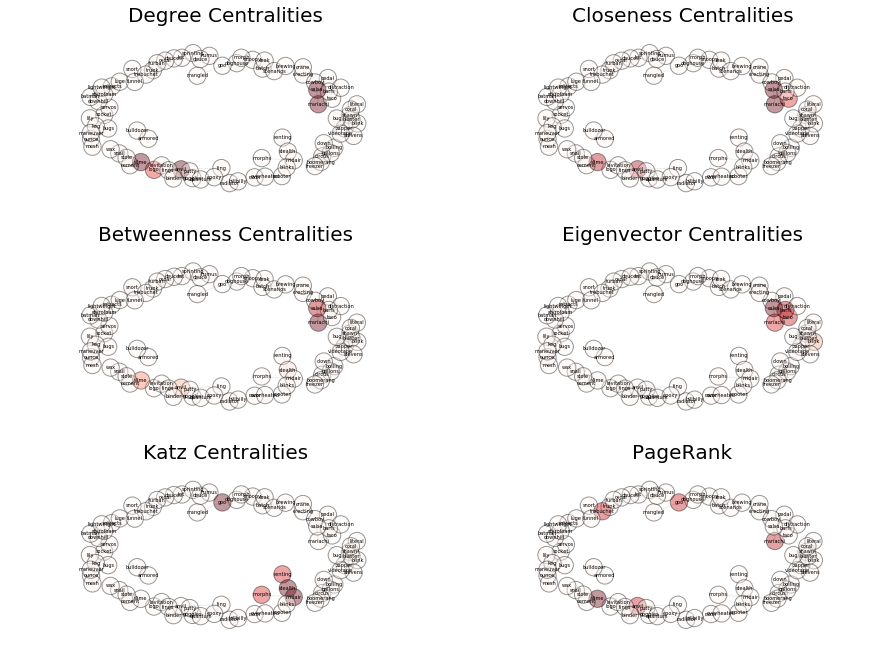

In [123]:
from tools import draw_centralities_subplots
centrali4=draw_centralities_subplots(GDCU, pos3, withLabels=True,labfs=5, figsi=(15, 15), ealpha=0.15, vals=True)

## 11.2 Generate Table of Centralities (Words Unique to D-C Group)
We list the centralities of the words unique to the Free Group calculated using the above metrics. Remember that this is a shortened list of words, with information content above 12.

In [124]:
# Generate Centralities Table
dfchc4=pd.DataFrame()
dfchc4.insert(0,'Common Nouns', centrali4[list(centrali.keys())[0]].keys())
u=1
for i,k in centrali4.items():
    dfchc4.insert(u,i,k.values())
dfchc4

,Common Nouns,page_rank,katz_centrality,degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality
0,goggles,0.018140,-0.018288,0.035714,0.042517,0.002008,7.127370e-160
1,sprinting,0.011765,0.052871,0.011905,0.011905,0.000000,7.127370e-160
2,shawn,0.011765,0.052871,0.011905,0.011905,0.000000,7.127370e-160
3,blink,0.011765,0.052871,0.011905,0.011905,0.000000,1.830731e-01
4,mariachi,0.006904,0.009604,0.011905,0.027056,0.000000,4.171163e-01
5,zapper,0.011765,0.052871,0.011905,0.011905,0.000000,7.127370e-160
6,circus,0.011765,0.052871,0.011905,0.011905,0.000000,7.127370e-160
7,anvil,0.011765,0.052871,0.011905,0.011905,0.000000,2.102726e-10
8,literal,0.017258,-0.077715,0.035714,0.035714,0.000574,7.127370e-160
9,pedal,0.011765,0.052871,0.011905,0.011905,0.000000,7.127370e-160


In [125]:
sstt = "Co-occurrences in the D-C Brainstorming Group"
part, nodper = print_communities(GDCU, sstt)

Number of communities of  Co-occurrences in the D-C Brainstorming Group  =  36
Community partition of  Co-occurrences in the D-C Brainstorming Group :
[['goggles', 'hillbilly'],
 ['sprinting', 'oscar'],
 ['shawn', 'stevens'],
 ['scooter', 'razor'],
 ['bug', 'zapper'],
 ['circus', 'clown'],
 ['anvil', 'logo', 'ting', 'tings'],
 ['crane', 'erecting'],
 ['renting', 'stealth', 'blinks'],
 ['coral', 'videotape'],
 ['boiling', 'gallons', 'freezer'],
 ['snoopy', 'doghouse'],
 ['socket', 'servos'],
 ['wax', 'putty', 'slime', 'snail'],
 ['snort', 'trunk'],
 ['cement', 'stole'],
 ['barfs', 'taco', 'mariachi', 'cowboy', 'salsa', 'blink'],
 ['lily', 'bugs'],
 ['distraction', 'pedal'],
 ['quantum', 'levitation'],
 ['downhill', 'luge'],
 ['midair', 'boomerang', 'morphs'],
 ['tnt', 'funnel', 'trebuchet'],
 ['overheated', 'radiator'],
 ['batman', 'retracts'],
 ['ounce', 'keg'],
 ['humus', 'turban'],
 ['armored', 'bulldozer'],
 ['blaster', 'literal'],
 ['maneuver', 'mesh'],
 ['brewing', 'batch'],
 ['le

## Observations ##
The observations for this analysis and the [corresponding analysis of convergent processes](https://nbviewer.jupyter.org/github/senthilchandrasegaran/jupyter-notebooks/blob/master/brainstorming-viz/convergence_infocontent_interactive.ipynb) are summarized in the Observations & Inferences section [here](https://nbviewer.jupyter.org/github/senthilchandrasegaran/jupyter-notebooks/blob/master/brainstorming-viz/convergence_infocontent_interactive.ipynb#Observations).